In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import shap
import os
import sys
import collections
import torch

from scipy import stats
from shapreg import shapley, games, removal, shapley_sampling
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection

from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)


module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as cate_models_masks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def plot_feature_values(feature_values):

    
    ind = np.argpartition(np.abs(feature_values).mean(0).round(2), -15)[-15:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(feature_values[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        X_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )
    
def plot_feature_values_ind(feature_values, indices):
    
    selected_sample = feature_values[indices]
    filtered_test = X_test[indices]
    
    ind = np.argpartition(np.abs(selected_sample).mean(0).round(2), -15)[-15:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(selected_sample[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        selected_sample[:, ind],
        filtered_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )

def normalize_data(X_train):
    
    X_normalized_train = (X_train - np.min(X_train, axis=0)) / (np.max(X_train, axis=0) - np.min(X_train, axis=0))

    return X_normalized_train

In [6]:
#### filtering out procedure

# fluid_cohort = pd.read_pickle("data/low_bp_survival.pkl")
#fluid_cohort = pd.read_pickle("data/trauma_team_activated.pkl")
fluid_cohort = pd.read_pickle("data/trauma_responder.pkl")

#
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='proc')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='ethnicity')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='residencestate')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='toxicologyresults')))]


x = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid",
                                                            "COV",
                                                            "TT",
                                                            "scenegcsmotor",
                                                            "scenegcseye",
                                                            "scenegcsverbal",
                                                            "edgcsmotor",
                                                            "edgcseye",
                                                            "edgcsverbal",
                                                            "outcome",
                                                            "sex_F",
                                                            "traumatype_P",
                                                            "traumatype_other"
                                                            ])]

### normalize x_train 
#x = x_train.values 

n, feature_size = x.shape
names = x.drop(["treated"], axis=1).columns
treatment_index = x.columns.get_loc("treated")
sex_index = x.columns.get_loc("sex_M")

var_index = [i for i in range(feature_size) if i != treatment_index]

x_norm = normalize_data(x)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             fluid_cohort["outcome"], 
                                             test_size=0.2, 
                                             random_state=10,
                                             stratify=fluid_cohort["outcome"]
                                    )

w_train = X_train[:, treatment_index]
w_test =  X_test[:, treatment_index]
X_train = X_train[:,var_index]
X_test = X_test[:, var_index]


device = "cpu"

learner_explanations = {}

#### Getting top 10 features from multiple runs. 

trials = 50
results_train = np.zeros((trials, len(X_train)))
results_test = np.zeros((trials, len(X_test)))


for i in range(trials):
    
    model = cate_models_masks.DRLearner(  
                                            X_train.shape[1],
                                            binary_y=(len(np.unique(y_train)) == 2),
                                            n_layers_out=2,
                                            n_units_out=30,
                                            batch_size=256,
                                            n_iter=500,
                                            nonlin="relu",
                                            device=device,
                                            )

    model.fit(X_train, y_train, w_train)
    
    results_train[i] = model(X_train).detach().cpu().numpy().flatten()
    results_test[i] = model(X_test).detach().cpu().numpy().flatten()

binary outcome
binary outcome
[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.6647117137908936, train_loss: 0.5515387058258057
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.631862461566925, train_loss: 0.4697921872138977
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5859771966934204, train_loss: 0.430330753326416
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5413253307342529, train_loss: 0.3779316246509552
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5150266289710999, train_loss: 0.34794774651527405
[po_estimator_0_impute_pos] Epoch: 250, current validation loss: 0.4908670485019684, train_loss: 0.299728125333786
[po_estimator_0_impute_pos] Epoch: 300, current validation loss: 0.47034910321235657, train_loss: 0.30493754148483276
[po_estimator_0_impute_pos] Epoch: 350, current validation loss: 0.4545704424381256, train_loss: 0.24669337272644043
[po_estimator_0_impute_pos] Epoch: 400, curr

In [34]:
import pickle 

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))

print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))


age_index = x.columns.get_loc("age")

print(age_index)
# with open(r"result_train_responder_drlearner.pkl", "wb") as output_file:

#     pickle.dump(results_train, output_file)

# with open(r"result_test_responder_drlearner.pkl", "wb") as output_file:

#     pickle.dump(results_test, output_file)

0.0183821000862994 0.07547465523158707
0.07685048520182088 0.11523585512089242
0


In [10]:
print(results_train.shape)

(50, 607)


average tx effect 0.0060558124
average tx effect 0.026442258


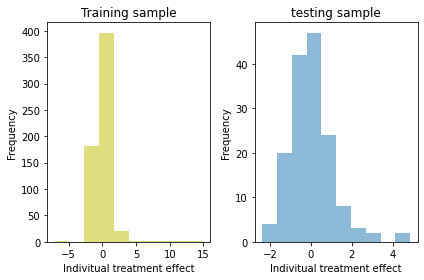

In [11]:
import matplotlib.pyplot as plt 

train_output = model(X_train).detach().cpu().numpy()
test_output = model(X_test).detach().cpu().numpy()

print("average tx effect", np.mean(train_output))
print("average tx effect", np.mean(test_output))

plt.subplot(1,2,1)
plt.hist(train_output, alpha= 0.5, color="y")

plt.title("Training sample")
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(test_output, alpha = 0.5)

plt.title("testing sample")
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")
plt.tight_layout()

In [32]:
sex_index = x.columns.get_loc("sex_M")

male = results_train[:, np.where(X_train[:,sex_index] == 1)[0]]
female = results_train[:, np.where(X_train[:,sex_index] == 0)[0] ]

print(male.shape, female.shape)

print("average tx effect: male", np.mean(male), np.std(male)/np.sqrt(male.shape[1]))
print("average tx effect: female", np.mean(female), np.std(female)/np.sqrt(female.shape[1]))

(50, 442) (50, 165)
average tx effect: male -0.04563321377912682 0.07722693970880021
average tx effect: female 0.18986554692580476 0.1845280134229806


In [45]:
age_index = x.columns.get_loc("age")

elder = results_train[:, np.where(X_train[:,age_index] >= 0.4)[0]]
younger = results_train[:, np.where(X_train[:,age_index] < 0.4)[0] ]

print(male.shape, female.shape)

print("average tx effect: male", np.mean(elder), np.std(elder)/np.sqrt(elder.shape[1]))
print("average tx effect: female", np.mean(younger), np.std(younger)/np.sqrt(younger.shape[1]))

(50, 442) (50, 165)
average tx effect: male 0.11417817984979 0.1241857285007968
average tx effect: female -0.057857975228431294 0.09254493294182312


(array([85., 91., 85., 77., 69., 87., 47., 34., 22., 10.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

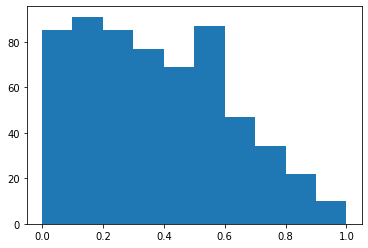

In [43]:
plt.hist(X_train[:,age_index])

In [246]:
tx = np.asarray([
    0.08203281,
    0.08250503,
    0.06909127,
    0.014995548,
    0.05894966,
    0.09413,
    0.026347587,
    0.095,

])

print(np.mean(tx), 1.96*np.std(tx)/np.sqrt(tx.shape[0]))

0.065381488125 0.01958733964161962


In [272]:
tx = np.asarray([
0.030421846,
0.02537185,
0.076443054,
0.0158,
0.07017463,
0.04159542,
0.14895725,
 0.15467
])

print(np.mean(tx), 1.96*np.std(tx)/np.sqrt(tx.shape[0]))

0.07042925625 0.035288410487281215


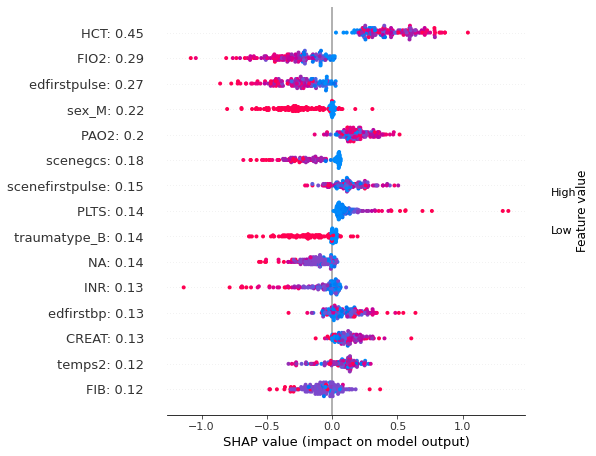

In [411]:
# Shapley value sampling
shapley_value_sampling_model = ShapleyValueSampling(model)


learner_explanations["shapley_sampling_0"] = shapley_value_sampling_model.attribute(
                                                 torch.from_numpy(X_test).to(device).requires_grad_(),
                                                n_samples=500,
                                                perturbations_per_eval=10,
                                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["shapley_sampling_0"])

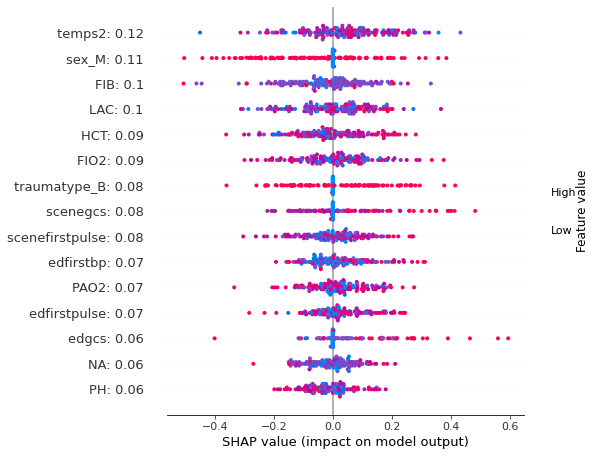

In [410]:
# Shapley value sampling
ig = IntegratedGradients(model)

learner_explanations["ig"] = ig.attribute(
                                    torch.from_numpy(X_test).to(device).requires_grad_(),
                                    n_steps=500,
                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["ig"])

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.


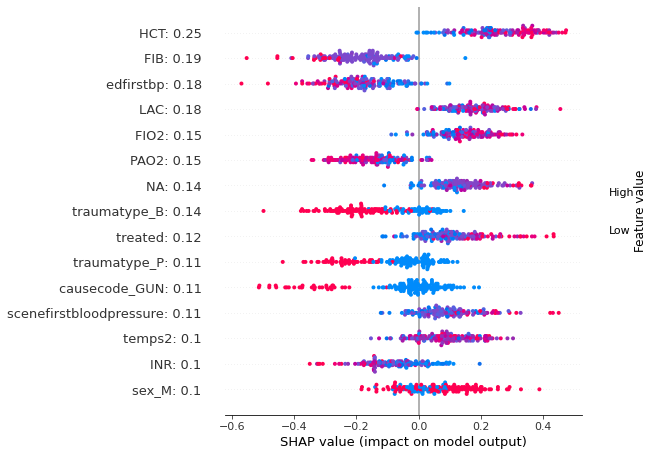

In [16]:

## Kernel shap
kernel_shap_model = KernelShap(model)

learner_explanations["KernelSHAP"] = kernel_shap_model.attribute(
                                             torch.from_numpy(X_test).to(device).requires_grad_(),
                                             n_samples=500,
                                             perturbations_per_eval=10
                                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["KernelSHAP"])

In [ ]:
learner_explanations["shapley_sampling"] = np.zeros((X_test.shape))
marginal_extension = removal.MarginalExtension(X_test, model)

for test_ind in range(len(X_test)):
    instance = X_test[test_ind]
    game = games.PredictionGame(marginal_extension, instance)
    explanation = shapley_sampling.ShapleySampling(game, thresh=0.03, batch_size=64)
    learner_explanations["shapley_sampling"][test_ind] = explanation.values.reshape(-1, X_test.shape[1])

plot_feature_values(learner_explanations["shapley_sampling"])

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.28s/it]
  9%|███▋                                    | 0.0914/1 [00:04<00:49, 54.62s/it]

In [29]:
male_indices = np.where(X_test[:,sex_index] == 1)

plot_feature_values_ind(learner_explanations["shapley_sampling"], male_indices)

KeyError: 'shapley_sampling'

In [30]:
plot_feature_values(learner_explanations["shapley_sampling"])

KeyError: 'shapley_sampling'

In [22]:
# import pickle 

# print(np.mean(results_train[:, 0, : ]), np.std(results_train[:, 0, : ])/np.sqrt(results_train.shape[2]))

# print(np.mean(results_test[:, 1, : ]), np.std(results_test[:, 1, : ])/np.sqrt(results_test.shape[2]))

# # with open(r"result_train_responder.pkl", "wb") as output_file:
    
# #     pickle.dump(results_train, output_file)

# # with open(r"result_test_responder.pkl", "wb") as output_file:
    
# #     pickle.dump(results_test, output_file)/

[  1   2   3   4   5   7   8   9  10  11  12  13  14  15  17  18  19  21
  23  25  27  28  30  31  33  34  35  36  40  42  43  44  45  46  47  48
  49  51  52  53  54  55  56  58  59  60  62  63  64  66  67  68  69  70
  72  73  74  75  79  80  81  82  83  85  86  87  88  89  90  91  93  94
  95  96  98  99 100 101 102 104 105 106 107 108 109 110 111 113 114 116
 117 118 119 121 122 123 129 130 131 132 133 134 135 136 138 139 140 142
 143 145 147 148 151]


In [24]:
sex_index = x.columns.get_loc("sex_M")

male = results_test[:, np.where(X_test[:,sex_index] == 1)[0]]
female = results_test[:, np.where(X_test[:,sex_index] == 0)[0] ]

print(male.shape, female.shape)

print("average tx effect: male", np.mean(male), np.std(male)/np.sqrt(male.shape[1]))
print("average tx effect: female", np.mean(female), np.std(female)/np.sqrt(female.shape[1]))

# plt.subplot(1,2,1)
# plt.hist(male_ate, alpha= 0.5, color="y")

# plt.title("Male - ITE")
# plt.xlabel("Indivitual treatment effect")
# plt.ylabel("Frequency")

# plt.subplot(1,2,2)
# plt.hist(female_ate, alpha = 0.5)

# plt.title("Female - ITE")
# plt.xlabel("Indivitual treatment effect")
# plt.ylabel("Frequency")
# plt.tight_layout()

(50, 113) (50, 39)
average tx effect: male -0.05818802156621607 0.09701225112566374
average tx effect: female 0.4681159022476715 0.3426700979747186


In [359]:
sex_index = x.columns.get_loc("sex_M")


(152, 47)
(113, 47) (39, 47)
average tx effect: male 0.4534431
average tx effect: female 0.5026876


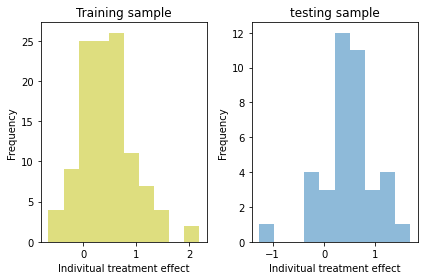

In [44]:
names = x.columns

names  = [i for i in names if i != "treated"]

In [45]:
names

['age',
 'scenegcs',
 'scenefirstbloodpressure',
 'scenefirstpulse',
 'scenefirstrespirationrate',
 'edfirstbp',
 'edfirstpulse',
 'edfirstrespirationrate',
 'temps2',
 'edgcs',
 'causecode_ABUSE',
 'causecode_AIR',
 'causecode_BIKE',
 'causecode_BITES',
 'causecode_CUT',
 'causecode_DROWN',
 'causecode_ENVIRON',
 'causecode_EXPLOSION',
 'causecode_FALL',
 'causecode_GUN',
 'causecode_MACHINE',
 'causecode_MC',
 'causecode_MV',
 'causecode_OTHER',
 'causecode_PEDESTRIAN',
 'causecode_RAILWAY',
 'causecode_STRUCK',
 'causecode_TRANSPORT',
 'sex_M',
 'traumatype_B',
 'traumatype_OTHER',
 'BD',
 'CFSS',
 'COHB',
 'CREAT',
 'FIB',
 'FIO2',
 'HCT',
 'HGB',
 'INR',
 'LAC',
 'NA',
 'PAO2',
 'PH',
 'PLTS',
 'PTT']